# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
# Algumas configurações para o matplotlib.
# %matplotlib inline

from IPython.core.pylabtools import figsize


figsize(8, 5)

sns.set()

In [3]:
countries = pd.read_csv("countries.csv", decimal=",")

In [4]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

countries.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


## Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

## Inicia sua análise a partir daqui

In [5]:
# Sua análise começa aqui.


## Questão 1

Quais são as regiões (variável `Region`) presentes no _data set_? Retorne uma lista com as regiões únicas do _data set_ com os espaços à frente e atrás da string removidos (mas mantenha pontuação: ponto, hífen etc) e ordenadas em ordem alfabética.

In [6]:
def q1():
    # Retorne aqui o resultado da questão 1.
    return sorted(list(countries["Region"].map(lambda x: x.strip()).unique()))
q1()

['ASIA (EX. NEAR EAST)',
 'BALTICS',
 'C.W. OF IND. STATES',
 'EASTERN EUROPE',
 'LATIN AMER. & CARIB',
 'NEAR EAST',
 'NORTHERN AFRICA',
 'NORTHERN AMERICA',
 'OCEANIA',
 'SUB-SAHARAN AFRICA',
 'WESTERN EUROPE']

## Questão 2

Discretizando a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`, quantos países se encontram acima do 90º percentil? Responda como um único escalar inteiro.

In [7]:
def q2():
    # Retorne aqui o resultado da questão 2.
    est = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
    xt = est.fit_transform(countries["Pop_density"].to_numpy().reshape(-1,1))
    return (xt > np.quantile(a=xt, q=.90)).sum()
q2()

23

# Questão 3

Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados? Responda como um único escalar.

In [8]:
pd.get_dummies(data=countries, columns=["Region", "Climate"]).columns[-17:]

Index(['Region_ASIA (EX. NEAR EAST)         ',
       'Region_BALTICS                            ',
       'Region_C.W. OF IND. STATES ',
       'Region_EASTERN EUROPE                     ',
       'Region_LATIN AMER. & CARIB    ',
       'Region_NEAR EAST                          ',
       'Region_NORTHERN AFRICA                    ',
       'Region_NORTHERN AMERICA                   ',
       'Region_OCEANIA                            ',
       'Region_SUB-SAHARAN AFRICA                 ',
       'Region_WESTERN EUROPE                     ', 'Climate_1.0',
       'Climate_1.5', 'Climate_2.0', 'Climate_2.5', 'Climate_3.0',
       'Climate_4.0'],
      dtype='object')

In [9]:
countries["Climate"].unique()

array([1. , 3. , 2. , nan, 4. , 1.5, 2.5])

In [10]:
def q3():
    # Retorne aqui o resultado da questão 3.
    return countries["Region"].nunique() + len(countries["Climate"].unique())
q3()

18

* note: Optei por usar `.nunique()` e `.unique()` pois além de entregar o resultado esperado e ser mais simples, acredito que tratar os dados nulos do "Climate" com outro valor diferente da mediana ou moda ('2') não é a melhor opção, uma vez que essa variável pode se uma categórica.

## Questão 4

Aplique o seguinte _pipeline_:

1. Preencha as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronize essas variáveis.

Após aplicado o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplique o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. Qual o valor da variável `Arable` após o [_pipeline_](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)? Responda como um único float arredondado para três casas decimais.

In [11]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142]

In [12]:
def q4():
    # Retorne aqui o resultado da questão 4.
    cols = countries.select_dtypes(include = "number").columns
    pipe = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
                             ('scaler', StandardScaler())])
    pipe.fit(countries[cols])
    return pipe.transform([test_country[2:]])[0][9].round(3) # A variável "Arable" é a 12º
q4()

-1.047

## Questão 5

Descubra o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.

Você deveria remover da análise as observações consideradas _outliers_ segundo esse método? Responda como uma tupla de três elementos `(outliers_abaixo, outliers_acima, removeria?)` ((int, int, bool)).

In [13]:
countries.Net_migration.describe()

count    224.000000
mean       0.038125
std        4.889269
min      -20.990000
25%       -0.927500
50%        0.000000
75%        0.997500
max       23.060000
Name: Net_migration, dtype: float64

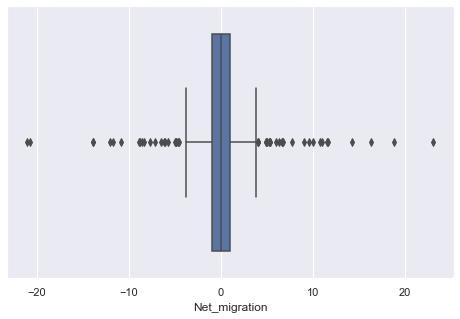

In [14]:
sns.boxplot(countries["Net_migration"]); # Haja outliers...

In [15]:
def q5():
    # Retorne aqui o resultado da questão 4.
    Q1, Q3 = countries["Net_migration"].quantile([.25, .75])
    IQR = Q3 - Q1

    out_low = Q1 - 1.5 * IQR
    out_high = Q3 + 1.5 * IQR

    outliers_abaixo = (countries["Net_migration"] < out_low).sum()
    outliers_acima = (countries["Net_migration"] > out_high).sum()
    return outliers_abaixo, outliers_acima, False # Por mais de serem outliers muitos paises se encontram nessa posição.
q5()

(24, 26, False)

## Questão 6
Para as questões 6 e 7 utilize a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`

Considere carregar as seguintes categorias e o dataset `newsgroups`:

```
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
```

**Referência:**
* [SKLearn-Feature_Extraction](https://scikit-learn.org/stable/modules/feature_extraction.html)

Aplique `CountVectorizer` ao _data set_ `newsgroups` e descubra o número de vezes que a palavra _phone_ aparece no corpus. Responda como um único escalar.

In [16]:
categories = ["sci.electronics", "comp.graphics", "rec.motorcycles"]
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)

In [17]:
def q6():
    # Retorne aqui o resultado da questão 4.
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(newsgroup.data)
    # Procuramos pelo índece e retiramos a soma da requencia encontrada
    feature_index = vectorizer.get_feature_names().index("phone")
    return X[:, feature_index].sum()
q6()

213

## Questão 7

Aplique `TfidfVectorizer` ao _data set_ `newsgroups` e descubra o TF-IDF da palavra _phone_. Responda como um único escalar arredondado para três casas decimais.

In [18]:
def q7():
    # Retorne aqui o resultado da questão 4.
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(newsgroup.data)
    feature_index = vectorizer.get_feature_names().index("phone")
    return np.round(X[:, feature_index].sum(), 3)
q7()

8.888